In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim



seed=100
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [2]:
import torch.nn as nn
import torch

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            #nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        self.encoder=Encoder(bottleneck_size,overparam=overparam,activation=activation,bn=bn,ch=ch,input_size=input_size)
        self.decoder=Decoder(bottleneck_size,overparam=overparam,activation=activation,bn=bn,ch=ch)

    def forward(self,x):
        return self.decoder(self.encoder(x))

    def encode(self,x):
        return self.encoder(x)

    def decode(self,z):
        return self.decode(z)


import numpy as np


### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer,print_partial=False):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if print_partial:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Instatiate the model


In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001


### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## train model 1

In [4]:
#%%
num_epochs = 20
npoints = 100
lim = 8
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder,decoder,device,
    train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])




 EPOCH 1/20 	 train loss 0.12088385969400406 	 val loss 0.06439171731472015

 EPOCH 2/20 	 train loss 0.06257537007331848 	 val loss 0.0589289665222168

 EPOCH 3/20 	 train loss 0.05544723942875862 	 val loss 0.05104660615324974

 EPOCH 4/20 	 train loss 0.04544556513428688 	 val loss 0.03991848602890968

 EPOCH 5/20 	 train loss 0.03621338680386543 	 val loss 0.032393671572208405

 EPOCH 6/20 	 train loss 0.030035460367798805 	 val loss 0.02752494253218174

 EPOCH 7/20 	 train loss 0.025935690850019455 	 val loss 0.024053245782852173

 EPOCH 8/20 	 train loss 0.022975368425250053 	 val loss 0.02158680185675621

 EPOCH 9/20 	 train loss 0.020785441622138023 	 val loss 0.01971910521388054

 EPOCH 10/20 	 train loss 0.019036689773201942 	 val loss 0.018116958439350128

 EPOCH 11/20 	 train loss 0.017517227679491043 	 val loss 0.01675570383667946

 EPOCH 12/20 	 train loss 0.016371121630072594 	 val loss 0.015704281628131866

 EPOCH 13/20 	 train loss 0.015493301674723625 	 val loss 0.01

In [ ]:

seed=42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

encoder2 = Encoder(encoded_space_dim=d)
decoder2 = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder2.to(device)
decoder2.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Train Model 2


 EPOCH 1/20 	 train loss 0.011961757205426693 	 val loss 0.011035568080842495

 EPOCH 2/20 	 train loss 0.011142284609377384 	 val loss 0.010842963121831417

 EPOCH 3/20 	 train loss 0.010920098051428795 	 val loss 0.010568512603640556

 EPOCH 4/20 	 train loss 0.010675578378140926 	 val loss 0.010289940983057022

 EPOCH 5/20 	 train loss 0.010440269485116005 	 val loss 0.010099424980580807

 EPOCH 6/20 	 train loss 0.010215336456894875 	 val loss 0.009891890920698643

 EPOCH 7/20 	 train loss 0.010008721612393856 	 val loss 0.009755728766322136

 EPOCH 8/20 	 train loss 0.009801381267607212 	 val loss 0.009549319744110107

 EPOCH 9/20 	 train loss 0.009610943496227264 	 val loss 0.009373387321829796

 EPOCH 10/20 	 train loss 0.009431836195290089 	 val loss 0.009163680486381054

 EPOCH 11/20 	 train loss 0.009257764555513859 	 val loss 0.008997018449008465

 EPOCH 12/20 	 train loss 0.009095920249819756 	 val loss 0.008779042400419712

 EPOCH 13/20 	 train loss 0.008938971906900406 	

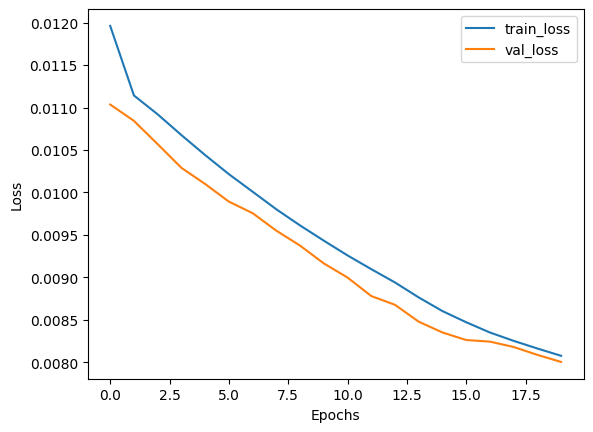

In [ ]:
#train the model
num_epochs = 20
npoints = 100
lim = 8
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
    train_loss =train_epoch(encoder2,decoder2,device,
    train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder2,decoder2,device,test_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
plt.plot(diz_loss['train_loss'])
plt.plot(diz_loss['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])

In [ ]:
import os

# Create the "checkpoints" directory if it doesn't exist
os.makedirs("checkpoints", exist_ok=True)

# Save the encoder and decoder weights
torch.save(encoder.state_dict(), "checkpoints/encoder.pth")
torch.save(decoder.state_dict(), "checkpoints/decoder.pth")


# Save the encoder and decoder weights
torch.save(encoder2.state_dict(), "checkpoints/encoder2.pth")
torch.save(decoder2.state_dict(), "checkpoints/decoder2.pth")


In [ ]:
# Instantiate the encoder and decoder models
#d=32
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
encoder2 = Encoder(encoded_space_dim=d)
decoder2 = Decoder(encoded_space_dim=d)

# Load the saved weights for the encoder and decoder models
encoder.load_state_dict(torch.load("checkpoints/encoder.pth"))
decoder.load_state_dict(torch.load("checkpoints/decoder.pth"))
encoder2.load_state_dict(torch.load("checkpoints/encoder2.pth"))
decoder2.load_state_dict(torch.load("checkpoints/decoder2.pth"))


<All keys matched successfully>

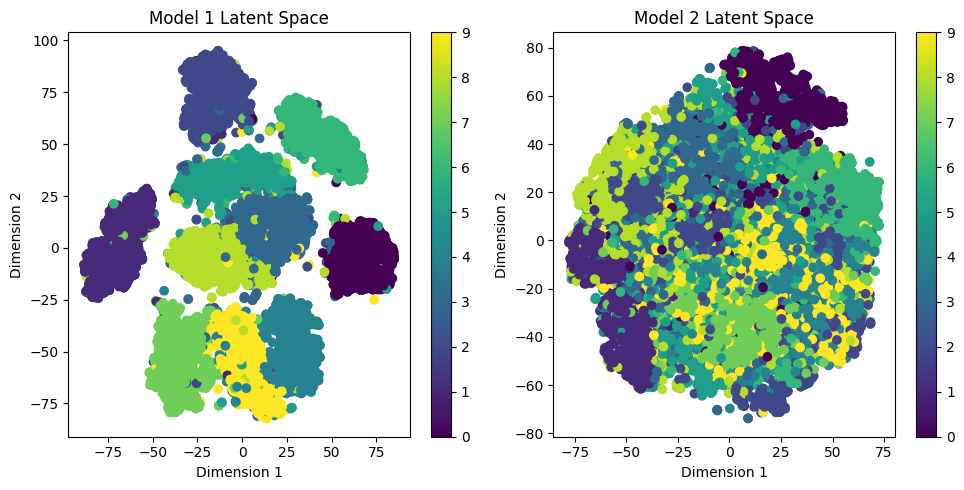

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the models to evaluation mode
encoder.eval()
encoder2.eval()
encoder.cuda()
encoder2.cuda()
# Create empty lists to store the encoded data and labels
encoded_data_model1 = []
encoded_data_model2 = []
labels = []

# Iterate through the validation loader
for image_batch, label_batch in valid_loader:
    # Move the image batch to the device
    image_batch = image_batch.to(device)
    
    # Encode the data using the first model
    encoded_data_1 = encoder(image_batch)
    encoded_data_model1.append(encoded_data_1.cpu().detach().numpy())
    
    # Encode the data using the second model
    encoded_data_2 = encoder2(image_batch)
    encoded_data_model2.append(encoded_data_2.cpu().detach().numpy())
    
    # Append the labels to the list
    labels.extend(label_batch.numpy())

# Concatenate the encoded data from both models
encoded_data_model1 = np.concatenate(encoded_data_model1)
encoded_data_model2 = np.concatenate(encoded_data_model2)

# Apply t-SNE to the encoded data
tsne_model1 = TSNE(n_components=2).fit_transform(encoded_data_model1)
tsne_model2 = TSNE(n_components=2).fit_transform(encoded_data_model2)

# Create a scatter plot of the t-SNE embeddings with labels as colors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(tsne_model1[:, 0], tsne_model1[:, 1], c=labels)
plt.title("Model 1 Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(tsne_model2[:, 0], tsne_model2[:, 1], c=labels)
plt.title("Model 2 Latent Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar()

plt.tight_layout()
plt.show()
